In [1]:
import os, sys
from os.path import dirname

root_path = os.path.abspath(os.getcwd())
if not root_path in sys.path: sys.path.insert(0, root_path)
    
print(sys.path)    

['D:\\GitWork\\ants_and_bees', 'C:\\opt\\miniconda3\\envs\\py37\\python37.zip', 'C:\\opt\\miniconda3\\envs\\py37\\DLLs', 'C:\\opt\\miniconda3\\envs\\py37\\lib', 'C:\\opt\\miniconda3\\envs\\py37', '', 'C:\\opt\\miniconda3\\envs\\py37\\lib\\site-packages', 'C:\\opt\\miniconda3\\envs\\py37\\lib\\site-packages\\win32', 'C:\\opt\\miniconda3\\envs\\py37\\lib\\site-packages\\win32\\lib', 'C:\\opt\\miniconda3\\envs\\py37\\lib\\site-packages\\Pythonwin', 'C:\\opt\\miniconda3\\envs\\py37\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Morpheus\\.ipython']


In [2]:
import argparse

def parse_args(**args):
    parser = argparse.ArgumentParser(description='Luna Nodule Detection by PyTorch')
    parser.add_argument("--cfg", type=str, default="configs/config_train.yaml",
                        help="Configuration filename.")
    # return parser.parse_args(**args)          # for python
    return parser.parse_known_args(**args)    # for jupyter notebook

args, _ = parse_args()
print(args)

Namespace(cfg='configs/config_train.yaml')


In [3]:
from configs.config_train import get_cfg_defaults

cfg = get_cfg_defaults()
cfg.merge_from_file(args.cfg)
cfg.freeze()
print(cfg)

DATA:
  ROOT_PATH: D:\GitWork\ants_and_bees\data\hymenoptera_data\
WORK:
  ROOT_PATH: D:\GitWork\ants_and_bees\


In [4]:
# Author: Morpheus Hsieh
# Ref: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

from __future__ import print_function, division  

import copy
import numpy as np
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

plt.ion()   # interactive mode

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation

trans_norm = transforms.Normalize(
    mean = [0.485, 0.456, 0.406],
    std  = [0.229, 0.224, 0.225]
)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        trans_norm
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        trans_norm
    ]),
}

data_dir = os.path.join(cfg.DATA.ROOT_PATH)

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
print('\nData transform: '); print(data_transforms);

print('\nImage dataset: '); print(image_datasets)

print('\nDataloaders: '); print(dataloaders)

print('\nDataset sizes: '); print(dataset_sizes)

print('\nClassnames: '); print(class_names)

print('\nDevice: '); print(device)


Data transform: 
{'train': Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'val': Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}

Image dataset: 
{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: D:\GitWork\ants_and_bees\data\hymenoptera_data\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    

AttributeError: 'dict' object has no attribute 'shape'

In [19]:
print(image_datasets['train'].__len__())
print(image_datasets['train'][1])

# print(image_datasets['val'].__len__())
# print(image_datasets['val'][1])

for i, traindata in enumerate(dataloaders['train']):
    print('i:',i)
    Data, Label = traindata
    print('data:', Data)
    print('Label:', Label)

244
(tensor([[[0.7077, 0.7248, 0.7933,  ..., 1.7523, 1.7523, 1.8037],
         [0.4508, 0.5193, 0.6563,  ..., 1.8893, 1.7694, 1.7694],
         [0.3994, 0.5707, 0.8789,  ..., 1.7865, 1.8037, 1.8550],
         ...,
         [1.8037, 1.7523, 1.6324,  ..., 2.0434, 2.0434, 1.9920],
         [1.6153, 1.4783, 1.5982,  ..., 2.0948, 2.0605, 1.9920],
         [1.5468, 1.6153, 1.7523,  ..., 2.0777, 2.0605, 1.9578]],

        [[1.1331, 1.0805, 1.1155,  ..., 1.6583, 1.7108, 1.7808],
         [1.0105, 1.0105, 1.0280,  ..., 1.9559, 1.6933, 1.6408],
         [1.0105, 1.0455, 1.2206,  ..., 1.8333, 1.7983, 1.9909],
         ...,
         [1.9209, 1.8508, 1.7633,  ..., 2.1485, 2.1660, 2.1485],
         [1.6583, 1.5357, 1.6583,  ..., 2.1835, 2.1660, 2.1134],
         [1.5707, 1.6408, 1.7983,  ..., 2.1835, 2.1485, 2.0784]],

        [[0.3742, 0.4265, 0.4439,  ..., 1.6291, 1.6814, 2.1171],
         [0.2696, 0.3045, 0.3393,  ..., 2.0125, 1.6988, 1.7163],
         [0.3393, 0.3916, 0.7402,  ..., 1.6640, 1.855

          [-0.4275, -0.4450, -0.3753,  ..., -0.8110, -0.8110, -0.8110]]]])
Label: tensor([0, 0, 0, 0])
i: 17
data: tensor([[[[ 1.2557,  1.2728,  1.2899,  ..., -1.3130, -1.2445, -1.1589],
          [ 1.1529,  1.2043,  1.2214,  ..., -1.3302, -1.1760, -1.0562],
          [ 1.1358,  1.2043,  1.2557,  ..., -1.2274, -1.1932, -1.1760],
          ...,
          [-1.3987, -1.4500, -1.4672,  ..., -0.7650, -0.6965, -0.7137],
          [-1.3987, -1.4329, -1.3815,  ..., -0.7822, -0.8164, -0.7650],
          [-1.3130, -1.3644, -1.3473,  ..., -0.6452, -0.8164, -0.7993]],

         [[ 1.4132,  1.4307,  1.5007,  ..., -0.9503, -1.0203, -1.1078],
          [ 1.3782,  1.4307,  1.4832,  ..., -1.0378, -1.1078, -1.1954],
          [ 1.3431,  1.3606,  1.3957,  ..., -1.0378, -1.0903, -1.1429],
          ...,
          [-1.0203, -0.9853, -0.9503,  ..., -0.5826, -0.6001, -0.6877],
          [-1.0553, -1.0378, -1.0028,  ..., -0.6352, -0.6001, -0.6001],
          [-1.0028, -0.9678, -0.9853,  ..., -0.6001, -0.6352,

i: 30
data: tensor([[[[ 1.5297,  1.5125,  1.4440,  ...,  0.9988,  0.8447,  0.6906],
          [ 1.4783,  1.4612,  1.3413,  ...,  0.9303,  0.8789,  0.8276],
          [ 1.4783,  1.4098,  1.2385,  ...,  1.0502,  1.0844,  1.0844],
          ...,
          [-0.7479, -0.7479, -0.7308,  ..., -0.4054, -0.3712, -0.3198],
          [-0.7479, -0.7137, -0.6965,  ..., -0.2171, -0.2513, -0.3027],
          [-0.7822, -0.7650, -0.7822,  ...,  0.1768,  0.0912, -0.0116]],

         [[ 1.0455,  1.0630,  1.0105,  ...,  0.6954,  0.5203,  0.3627],
          [ 1.0105,  0.9755,  0.8354,  ...,  0.6254,  0.5728,  0.5378],
          [ 0.9755,  0.8880,  0.7129,  ...,  0.7129,  0.7829,  0.7829],
          ...,
          [-0.8803, -0.8978, -0.9328,  ..., -0.4951, -0.4601, -0.4076],
          [-0.8452, -0.8978, -0.9153,  ..., -0.3200, -0.4076, -0.4076],
          [-0.9328, -0.9503, -0.9853,  ...,  0.0651, -0.0224, -0.1099]],

         [[ 0.6879,  0.7054,  0.5834,  ...,  0.3219,  0.2696,  0.1476],
          [ 0.6182

          [ 1.4025,  1.5420,  1.5594,  ..., -0.4798, -1.4384, -1.7522]]]])
Label: tensor([1, 1, 0, 1])
i: 44
data: tensor([[[[-1.2617, -1.3130, -1.3473,  ..., -0.6452, -0.7479, -0.7650],
          [-1.2959, -1.3302, -1.3644,  ..., -0.6623, -0.7308, -0.7308],
          [-1.2959, -1.3473, -1.3644,  ..., -0.6623, -0.7137, -0.6794],
          ...,
          [ 0.6906,  0.7077,  0.7419,  ..., -1.4329, -1.4329, -1.4329],
          [ 0.5364,  0.6906,  0.7933,  ..., -1.4158, -1.4329, -1.4329],
          [ 0.3652,  0.4508,  0.6049,  ..., -1.4158, -1.4158, -1.4158]],

         [[-0.6176, -0.6527, -0.6877,  ..., -0.4601, -0.5476, -0.6176],
          [-0.6176, -0.6702, -0.7052,  ..., -0.4426, -0.5476, -0.6001],
          [-0.6527, -0.6877, -0.7052,  ..., -0.4426, -0.5126, -0.5826],
          ...,
          [ 1.1331,  1.2206,  1.3256,  ..., -0.8102, -0.8102, -0.8102],
          [ 0.9755,  1.0805,  1.2031,  ..., -0.7927, -0.8102, -0.8102],
          [ 0.8704,  1.0280,  1.1155,  ..., -0.7927, -0.8102,

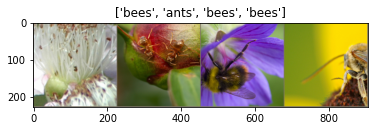

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp  = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    inp  = std * inp + mean
    inp  = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [13]:
print(dataloaders['train'])

In [8]:
# Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
# Visualizing the model predictions

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [10]:
# Finetuning the convnet

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
# Train and evaluate

model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25
)

Epoch 0/24
----------
train Loss: 0.4821 Acc: 0.7705
val Loss: 0.2419 Acc: 0.8889

Epoch 1/24
----------
train Loss: 0.3970 Acc: 0.8443
val Loss: 0.3068 Acc: 0.8562

Epoch 2/24
----------
train Loss: 0.2921 Acc: 0.8811
val Loss: 0.2144 Acc: 0.9020

Epoch 3/24
----------
train Loss: 0.3981 Acc: 0.8566
val Loss: 0.2802 Acc: 0.8889

Epoch 4/24
----------
train Loss: 0.6022 Acc: 0.7828
val Loss: 0.2307 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.4364 Acc: 0.8156
val Loss: 0.3316 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.4220 Acc: 0.8566
val Loss: 0.6127 Acc: 0.8105

Epoch 7/24
----------
train Loss: 0.4619 Acc: 0.8402
val Loss: 0.3499 Acc: 0.8758

Epoch 8/24
----------
train Loss: 0.2472 Acc: 0.8975
val Loss: 0.2520 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.3495 Acc: 0.8566
val Loss: 0.2286 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2594 Acc: 0.8975
val Loss: 0.2342 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.2823 Acc: 0.8730
val Loss: 0.2578 Acc: 0.9085

Ep